![Titanic Sinking](http://www.titanicuniverse.com/wp-content/uploads/2009/10/titanic-sinking-underwater.jpg)

<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>I. Titanic baseline models
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Understanding basic model
performance</center></p>

For this analysis we use the <b>Titanic Kaggle Competition</b> dataset found on the Kaggle Data
Repository at the following location:

<a href=https://www.kaggle.com/c/titanic/data>Titanic Kaggle Competition Dataset</a>

The objective of the analysis is to classify survivors of the Titanic disaster of 1912 according to
survival.

We aim to achieve this by following the ML pipeline approach of deploying a variety of ML techniques
to build a final predictive model. This particular analysis comprises 4 notebooks as follows:

 1. <i>titanic_baseline</i> - <b>This notebook</b>, baseline predictive models (quick and dirty) to
 compare later results against
 2. <i>titanic_eda</i> - Exploratory Descriptive Analysis (EDA)
 3. <i>titanic_features</i> - Perform feature engineering
 4. <i>titanic_final_model</i> - Final model

We hope to gain valuable insights by following this process. The various steps in the process can be
elaborated on as follows (the various notebooks will focus on different parts of the process as
indicated):

- Load data (<i>all notebooks</i>)
- Prepare data
    - Clean data (<i>notebook 2</i>)
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data (<i>notebook 2</i>)
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data (<i>notebook 3</i>)
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data (if not done in previous steps)
        - Feature selection/ importance analysis
- Build model (<i>notebooks 1 & 4</i>)
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model (<i>notebooks 1 & 4</i>)
    - Accuracy testing
- Analysis of results (<i>notebook 1 & 4</i>)
    - Response curves
    - Accuracy analysis
    - Commentary

The data dictionary for this dataset is as follows:

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival	| 0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex | male, female |
|Age | Age in years | Continuous |
|sibsp | # of siblings / spouses aboard the Titanic | 0, 1, 2, ..|
|parch | # of parents / children aboard the Titanic | 0, 1, 2 ..|
|ticket | Ticket number | PC 17599, STON/O2. 3101282, 330877 |
|fare | Passenger fare | Continuous |
|cabin | Cabin number | C123, C85, E46 |
|embarked | Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

Let us start the analysis for <b>notebook 1</b>!

Our approach for this notebook will be to take shortcuts and rapidly build 4 models to get
an idea of the strength of the signal in the data as well as where there might be issues
with the data, or obvious areas for improvement for the model. The models we will build
are the following:

 1. Logistic regression: Bread and butter classification model - Aim is to obtain an idea of how a
 classical linear model performs
 2. Multi-layer Perceptron (MLP): Understand how a simple non-linear model performs
 3. Decision Tree: Provide visual analysis of variable importance and strength of association
 4. Random Forest: Use model that good at dealing with unprocessed categorical variables in order to
 ascertain potential gains of pre-processing in next steps

We will use the scikit-learn libraries to build the prototype models from first principles. In later
notebooks we will use Keras and PyTorch to build the final models.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from numpy import isnan
from patsy.highlevel import dmatrix
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from src.visualization.visualize_titanic import plot_confusion_matrix, plot_roc_curve, \
    plot_feature_importance, plot_feature_importance_log, plot_feature_importance_dec, plotVar, \
    plotAge, plotContinuous, plotCategorical, plot_learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, \
    GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<h1 id = "load" style = "font-family:verdana; background-color:#C5D6FA"><center>Load Data</center></h1>

In [2]:
# Import data
df_train = pd.read_csv('../data/external/train.csv', header = None, names = ['passenger_id',
                      'survived', 'p_class', 'name', 'sex', 'age', 'sib_sp', 'parch',
                      'ticket', 'fare', 'cabin', 'embarked'],
                       index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                       skiprows=1, sep=',', skipinitialspace=True)

#### Train Data

In [3]:
df_train.head(20)
print(df_train.shape)


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


(891, 12)


In [4]:
# Import data
df_test = pd.read_csv('../data/external/test.csv', header = None, names = ['passenger_id',
                     'p_class', 'name', 'sex', 'age', 'sib_sp', 'parch', 'ticket', 'fare',
                     'cabin', 'embarked'],
                      index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                      skiprows=1, sep=',', skipinitialspace=True)

#### Test Data

In [5]:
df_test.head(20)
print(df_test.shape)
df_orig = df_test.copy()

,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


(418, 11)


The first thing to note is that the dataset read from csv file has 891 rows and 12 data
columns. This is different to the Kaggle data dictionary claiming 891 rows and 10 data
columns.

The two extra fields are name and ticket. These unstructured text variables will require
pre-processing. Let us do minimal exploration of the data and then start building our
baseline models!

<h1 id = "clean" style = "font-family:verdana; background-color:#C5D6FA"><center>Clean data
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Basic data cleaning, more
to follow in next notebook...</center></p>

In [6]:
# Create first stab at an improvement, start with the obvious variables to create a quick model.
df_train = df_train.loc[:, ['survived', 'p_class', 'name', 'sex', 'age', 'sib_sp', 'parch',
                            'ticket', 'fare', 'cabin', 'embarked']]

In [7]:
df_test = df_test.loc[:, ['p_class', 'name', 'sex', 'age', 'sib_sp', 'parch', 'ticket',
                          'fare', 'cabin', 'embarked']]

In [8]:
# Type of data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   p_class   891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sib_sp    891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [9]:
# Type of data
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p_class   418 non-null    int64  
 1   name      418 non-null    object 
 2   sex       418 non-null    object 
 3   age       332 non-null    float64
 4   sib_sp    418 non-null    int64  
 5   parch     418 non-null    int64  
 6   ticket    418 non-null    object 
 7   fare      417 non-null    float64
 8   cabin     91 non-null     object 
 9   embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


From the high level checks we can see that there are missing values in the following
fields: age, fare and embarked.

In [10]:
# Check for null values
df_train.isnull().sum()

# Actual null values
df_train[df_train.isnull().any(axis=1)]

survived      0
p_class       0
name          0
sex           0
age         177
sib_sp        0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
884,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [11]:
# Check for null values for test data
print(df_test.isnull().sum())
# Actual null values
df_test[df_test.isnull().any(axis=1)]

p_class       0
name          0
sex           0
age          86
sib_sp        0
parch         0
ticket        0
fare          1
cabin       327
embarked      0
dtype: int64


,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
412,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


We observed 177 null values for <i>age</i> and 2 for <i>embarked</i> for <i>training
data</i> and 86 null values for <i>age</i> and 1 for <i>fare</i> for <i>testing data</i>.

<h1 id = "explore" style = "font-family:verdana; background-color:#C5D6FA"><center>Explore data
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Basic exploration, more
to follow in next notebook...</center></p>

We start by looking at the number of unique records per variable.

In [12]:
print(df_train.nunique())

survived      2
p_class       3
name        891
sex           2
age          88
sib_sp        7
parch         7
ticket      681
fare        248
cabin       147
embarked      3
dtype: int64


There are no columns with only one value. We therefore retain all columns for ML purposes as there is
enough variability to warrant using the data. There are many variables with fewer than 10 levels which
 could be considered as categorical. Based on our initial assessment of the data we will work with
 levels of measurement for the data as follows:

- p_class (ordinal) - we will revisit type of encoding later
- sex (binary) - recode (female - yes or no)
- age (continuous)
- sib_sp (ordinal) - check correlation - revisit encoding
- parch (ordinal) - check correlation - revisit encoding
- fare (continuous)
- embarked (nominal) - recode (one hot encode) - probably categorical

At this point it seems as if we mainly have nominal and binary categorical data. We need to One Hot
Encode one variable i.e. embarked. We will leave the ordinal data as is for the initial analysis i.e.
label encode it. Next we look at the distribution of the data.

We now separate continuous and categorical variables for further analysis.

In [13]:
# Separate continuous and categorical variables
names_con = ('fare', 'age')
names_con_plot = ('survived', 'fare', 'age')
names_cat = ('survived', 'p_class', 'sex', 'sib_sp', 'parch', 'embarked')
names_cat_test = ('p_class', 'sex', 'sib_sp', 'parch', 'embarked')

df_train_con = df_train.loc[:, names_con]
df_train_con_plot = df_train.loc[:, names_con_plot]
df_train_cat = df_train.loc[:, names_cat]

df_test_con = df_test.loc[:, names_con]
df_test_cat = df_test.loc[:, names_cat_test]

# Plotting label dictionary
plot_con = [('fare', 'Fare'),
            ('age', 'Age')]
plot_con_plot = [('survived', 'Survived'),
            ('fare', 'Fare'),
            ('age', 'Age')]
plot_cat = ['survived', ['Yes', 'No'],
            ('p_class', ['1st', '2nd', '3rd']),
            ('sex', ['Male', 'Female']),
            ('sib_sp', '# siblings or spouses'),
            ('parch', '# parents or children'),
            ('embarked', ['Cherbourg', 'Queenstown', 'Southampton'])]

We observe that we have two candidates for continuous variables here (age and fare). With all the
categorical variables present, it is likely that a tree model would be better suited to this problem
unless significant feature engineering on categorical features is performed to ensure features are
optimally encoded, transformed and scaled for a linear model or neural network.

Let's continue with the high level analysis.

The overall survival rate was as follows (based on the training dataset):

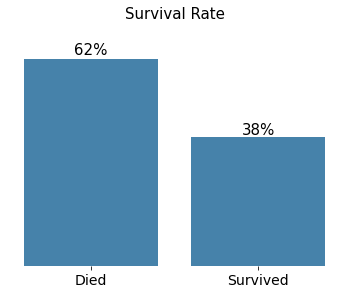

In [14]:
# Plot outcome counts.
outcome_counts = df_train_cat['survived'].value_counts(normalize = True)

base_color = sns.color_palette()[0]
ax = sns.barplot(x=outcome_counts.index, y=outcome_counts.values, alpha=0.9, color=base_color)
ax.xaxis.label.set_size(20)
#ax.title.set_size(10)

legend_labels = ['Died', 'Survived']
_ = plt.xticks(fontsize=14, ticks=ax.get_xticks(), labels=legend_labels)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
_ = plt.yticks([])

_ = plt.title('Survival Rate', fontsize=15, pad=30)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    _ = ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center', fontsize=15)

plt.show();


The survival statistics are as follows:


In [15]:
print(df_train_cat['survived'].value_counts())
print("\n")

0    549
1    342
Name: survived, dtype: int64




We observe that 38% of passengers survived and 62% died. These statistics correspond with the narrative on survival
rate quoted in the background information on Kaggle. There it is quoted that around 32% survived and 68% died. The
sample we are working with is thus representative of the overall population, which is important to note.

We observe that the target variable contains unbalanced classes. We need to consider revisiting the unbalanced
classes at a later stage - depending on the accuracy of our models. For now, we will forge ahead.

Next we will consider class level counts for categorical variables.

#### Categorical variable overview

In [16]:
# Class level counts for categorical variables.
for variable in names_cat:
    print(df_train_cat[variable].value_counts(normalize = True).mul(100).round(1).astype(str) + '%')
    print("\n")

0    61.6%
1    38.4%
Name: survived, dtype: object


3    55.1%
1    24.2%
2    20.7%
Name: p_class, dtype: object


male      64.8%
female    35.2%
Name: sex, dtype: object


0    68.2%
1    23.5%
2     3.1%
4     2.0%
3     1.8%
8     0.8%
5     0.6%
Name: sib_sp, dtype: object


0    76.1%
1    13.2%
2     9.0%
5     0.6%
3     0.6%
4     0.4%
6     0.1%
Name: parch, dtype: object


S    72.4%
C    18.9%
Q     8.7%
Name: embarked, dtype: object




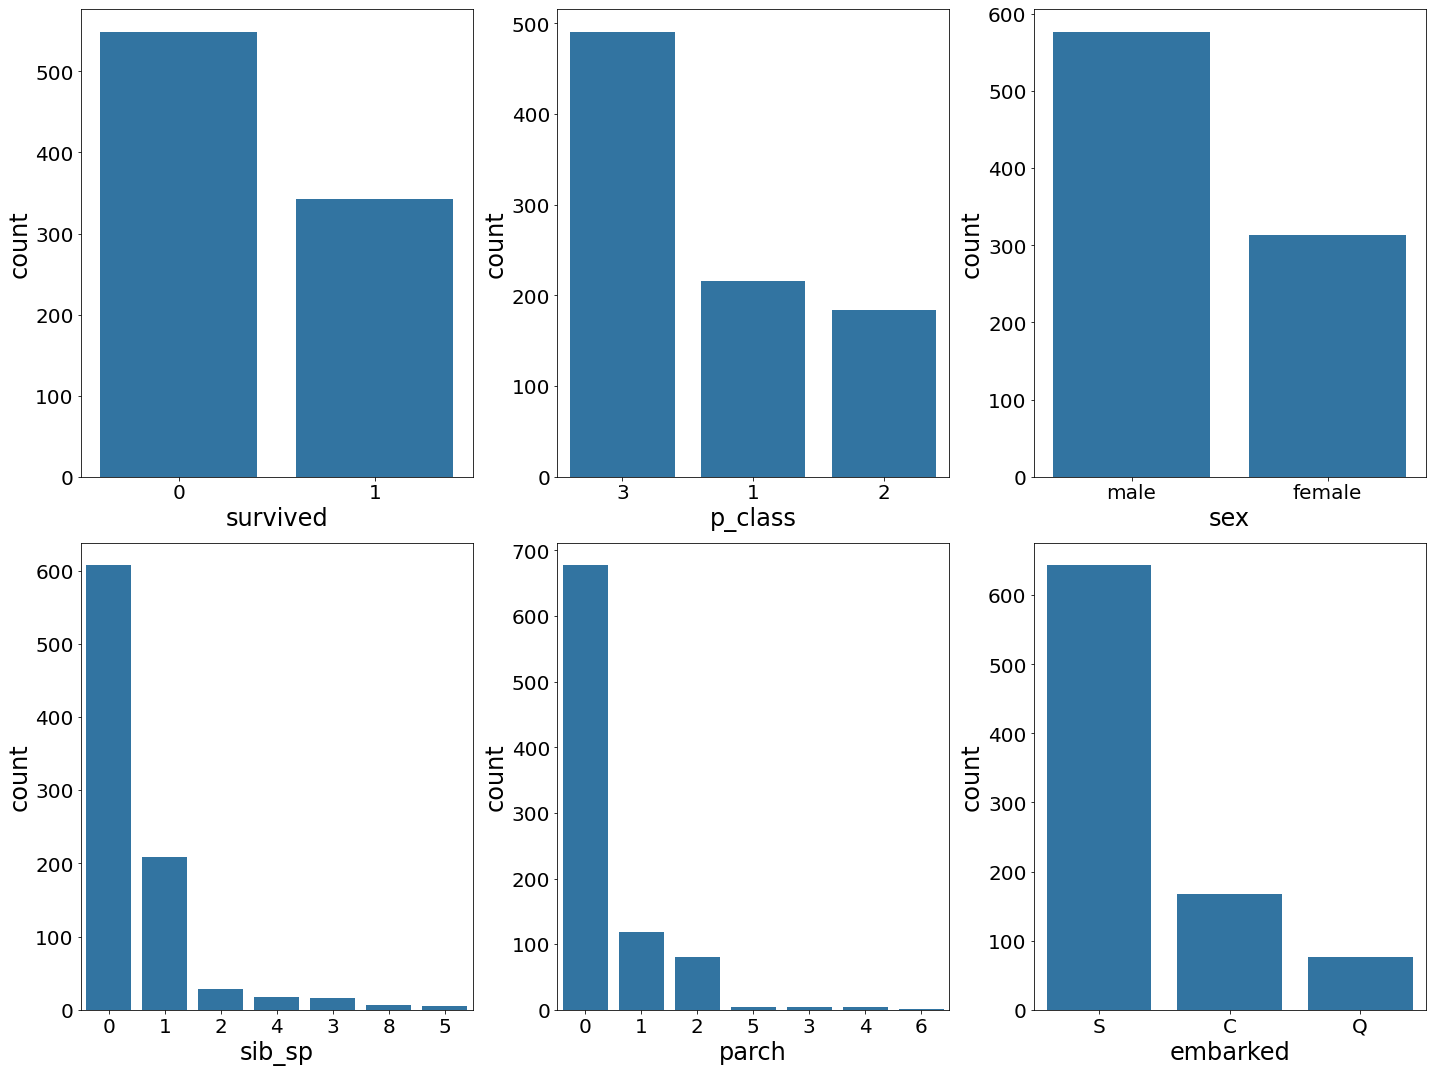

In [17]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(2, 3, figsize=(20, 15));
base_color = sns.color_palette()[0]
for variable, subplot in zip(names_cat, ax.flatten()):
    subplot.xaxis.label.set_size(24)
    subplot.yaxis.label.set_size(24)
    subplot.tick_params('y', labelsize = 20);
    subplot.tick_params('x', labelsize = 20);
    cat_order = df_train_cat[variable].value_counts().index
    cp = sns.countplot(data = df_train_cat, x = variable, order = cat_order, ax=subplot, color=base_color)
    plt.tight_layout()

From the categorical variables we observe that there were approximately twice as many passengers in class 3 than either
class 1 or 2. We also observe that there were nearly twice as many males as females on the Titanic. We also observe
that more than two thirds of passengers did not have any siblings on board. Likewise we observe that more than two
thirds did not have a father or child on board.

It is therefore fair to say that the majority of passengers were either couples or single travellers without children
. In the case where families did travel, the majority of families had one or two children. Very few families with
more children were on board the Titanic.

We also see that more than two thirds of passengers departed from Southampton.

Many of these variables could contribute o correlation with survival at face value e.g. it stands to reason that
preference would have been given in lifeboats to women and children, and that more affluent travellers would have had
access to better lifeboats. We will however test these hypotheses in this analysis.

#### Continuous variable overview

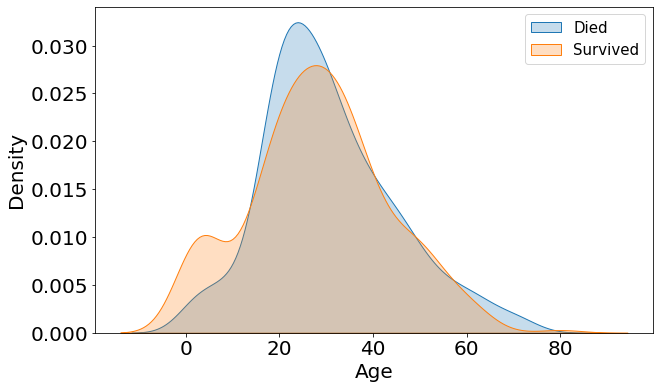

In [18]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), squeeze=False)
_ = plotAge(df=df_train_con_plot, axes=axes, single_plot=True);


From the age distribution plot we can see that more children under the age of 15 survived than died in the incident. 
We can see that more individuals between the ages of 20 and 40 died than survived. We can also see that more 
individuals above the age of 80 survived compared to dying.

We can also see that the majority of individuals on the cruise were between the ages of 20 to 40. There were fewer
teenagers compared to children under 10. There were comparatively fewer elderly people on board i.e. above 60.

In [19]:
# 5 number summary.
df_train_con.describe()


,fare,age
count,891.000000,714.000000
mean,32.204208,29.699118
std,49.693429,14.526497
min,0.000000,0.420000
25%,7.910400,20.125000
50%,14.454200,28.000000
75%,31.000000,38.000000
max,512.329200,80.000000


The fare distribution is severely skewed to the right. The kurtosis of the plot is very high with most values
clustered closely around the median value of 14. There was a non-significant but relatively smaller number of fares
spread between teh values of 30 and 500.

The age distribution was as previously discussed, with a minimum of 6 months and maximum of 80 years old. The
distribution is fairly symmetrical with a slight skew to the right. There is a young child bump to the left of the
distribution.

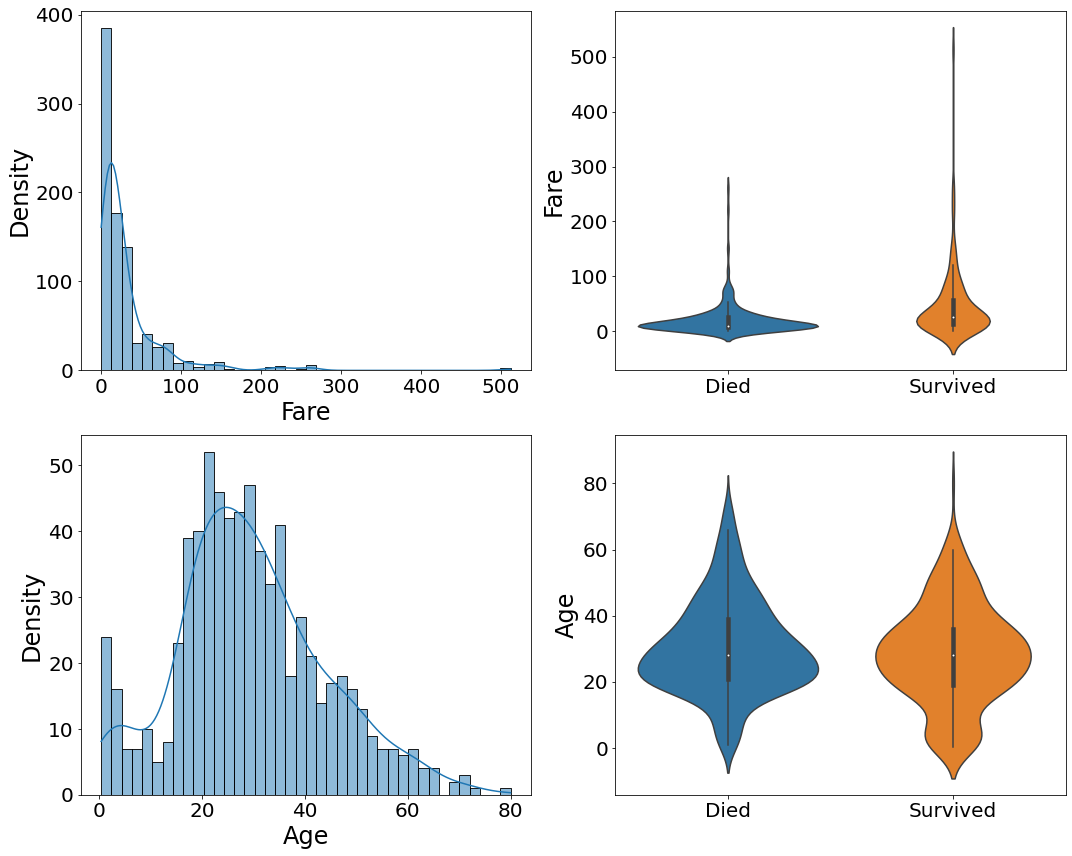

In [20]:
# Continuous density plot
fig_continuous, axes = plt.subplots(nrows=len(names_con_plot)-1, ncols=2, figsize=(15, 12))

# Plot frequency plot/ histogram
_ = sns.histplot(x=plot_con[0][0], kde=True, data=df_train_con_plot, ax=axes[0][0], bins=40);
_ = axes[0][0].set(xlabel=plot_con[0][1], ylabel='Density');
axes[0][0].xaxis.label.set_size(24)
axes[0][0].yaxis.label.set_size(24)
axes[0][0].tick_params('y', labelsize = 20);
axes[0][0].tick_params('x', labelsize = 20);

# Plot violin plot
_ = sns.violinplot(x='survived', y=plot_con[0][0], data=df_train_con_plot, ax=axes[0][1]);
_ = axes[0][1].set(xlabel='', ylabel=plot_con[0][1]);
axes[0][1].xaxis.label.set_size(24)
axes[0][1].yaxis.label.set_size(24)
axes[0][1].tick_params('y', labelsize = 20);
axes[0][1].tick_params('x', labelsize = 20);
_ = axes[0][1].set_xticklabels(['Died', 'Survived'])

# Plot frequency plot/ histogram
_ = sns.histplot(x=plot_con[1][0], kde=True, data=df_train_con_plot, ax=axes[1][0], bins=40);
_ = axes[1][0].set(xlabel=plot_con[1][1], ylabel='Density');
axes[1][0].xaxis.label.set_size(24)
axes[1][0].yaxis.label.set_size(24)
axes[1][0].tick_params('y', labelsize = 20);
axes[1][0].tick_params('x', labelsize = 20);

# Plot violin plot
_ = sns.violinplot(x='survived', y=plot_con[1][0], data=df_train_con_plot, ax=axes[1][1]);
_ = axes[1][1].set(ylabel=plot_con[1][1], xlabel='');
axes[1][1].xaxis.label.set_size(24)
axes[1][1].yaxis.label.set_size(24)
axes[1][1].tick_params('y', labelsize = 20);
axes[1][1].tick_params('x', labelsize = 20);
_ = axes[1][1].set_xticklabels(['Died', 'Survived'])

plt.tight_layout()

The violin plot for <i>fare</i> indicates that there is correlation between fare and survival as more people paying a
low fare died and chances of survival increased for higher fares, as well as lower fares close to zero (possibly for
children travelling at very low cost).

The plot for <i>age</i> indicates a similar pattern with higher survival for children below 10 and higher mortality
between ages of 20 and 40. The relative likelihood of survival increases again around 40 years of age as you go into
the older ages.


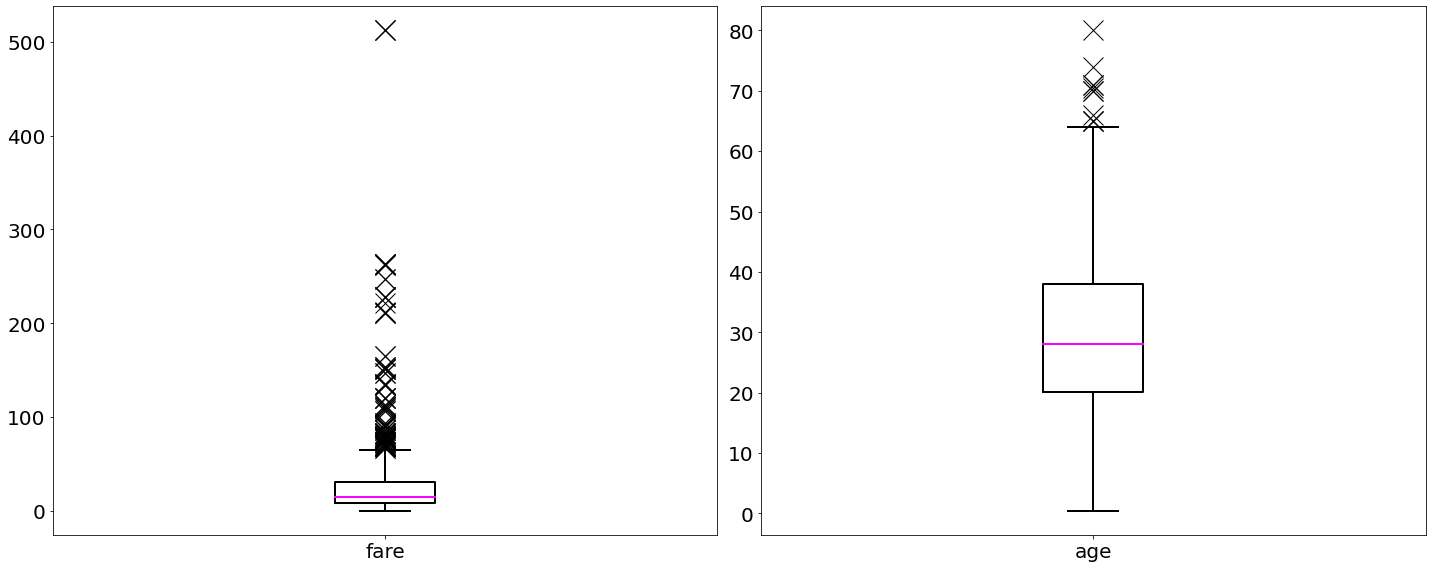

In [21]:
# Boxplot of continuous variables
medianprops = {'color': 'magenta', 'linewidth': 2}
boxprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
whiskerprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
capprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
flierprops = {'color': 'black', 'marker': 'x', 'markersize': 20}

_ = df_train_con.plot(kind='box', subplots=True, figsize=(20, 8), layout=(1,2), fontsize = 20, medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops);
_ = plt.tight_layout();
_ = plt.show();


The distributions of the <i>fare</i> and <i>age</i> variables show that fare is skewed heavily to the right, with the
median skewed to the left of the distribution as expected. The values in the final quintile are spread over wide area
with quite a few outliers. This distribution is heavy tailed, as can be expected of many financial distributions.

The <i>age</i> distribution is fairly symmetrical, with a few outliers to the right, but nothing out of the ordinary.
Most of the values are bundled symmetrically around the median of 28, which is quite a young age for the average
traveller.

<h1 id = "transform" style = "font-family:verdana; background-color:#C5D6FA"><center>Transform
variables
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Imputation of missing
values, scaling of variables and creating interaction terms</center></p>

It is clear from all our analyses that there are many categorical variables strongly
correlated with survival. It is also clear that there are many strong variable interactions
in the data.

It therefore makes sense to experiment with binning of the two continuous variables i.e. age
 and fare and to manually perform some interactions modelling to see if we can obtain more
 consistent results with our predictive models.

We have already looked at the age variable in detail before, let's have another look at the
fare variable:

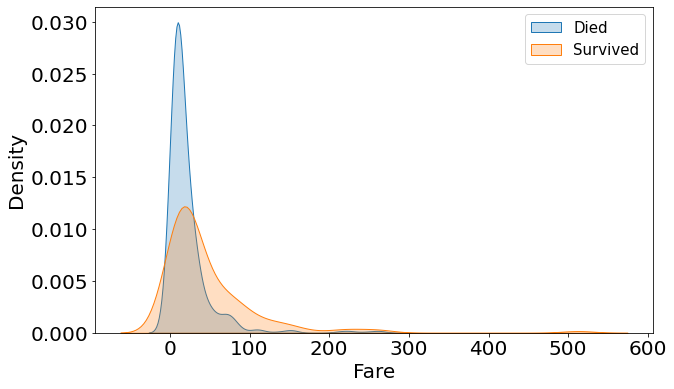

In [22]:
fig_fare, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), squeeze=False)

_ = sns.kdeplot(data=df_train_con_plot.loc[(df_train_con_plot['survived'] == 0), 'fare'],
                shade = True, label = 'Died')
_ = sns.kdeplot(data=df_train_con_plot.loc[(df_train_con_plot['survived'] == 1), 'fare'],
                shade = True, label = 'Survived')
_ = plt.xlabel('Fare', fontsize=20)
_ = plt.ylabel('Density', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
_ = plt.legend(fontsize=15)
plt.show()


We can bin this variable quite easily.

As age and fare have missing values, we need to impute this at time of model building to
avoid data leakage. We will therefore go ahead with the model building process and bin these
 variables after missing values have been replaced.

We will now build the following models as previously discussed:

 1. Logistic regression
 2. Multi-layer Perceptron (MLP)
 3. Decision Tree
 4. Random Forest

Our strategy is to build our own <i>validation strategy</i> based on the training set for which
we have labels. We will do this by splitting this set into training and testing sets according to
a 75%/ 25% split. Any hyper-parameter optimisation will be done by using <i>cross validation</i>
on the 75% test set. The 25% testing set will be used for our final test before we apply the
results to the provided test set for submission.

We therefore now start by splitting the response and features for the training set as previously
discussed.

We will be using this dataset for all our models from here onwards. We also perform minor
transformations such as encoding the <i>sex</i> variable for test and training sets. We also One
Hot Encode the <i>embarked</i> variable. We drop one of the categories for embarked to avoid
multi-collinearity (dummy variable trap).

In [23]:
df_train['age_missing'] = df_train.apply(lambda row: 1 if np.isnan(row['age']) else 0, axis=1)
df_test['age_missing'] = df_test.apply(lambda row: 1 if np.isnan(row['age']) else 0, axis=1)

# We will now transform some variables by grouping categories together based on our EDA
# analysis. We also encode categorical variables to numeric values in order to do the ML
# analysis.
# These transformations would not result in data leakage, and can hence be done before we
# split the data into training and testing sets.

# Make a copy of original dataset before imputation - we need the original for further
# analysis.
df_train_trans = df_train.copy()
df_test_trans = df_test.copy()

# Creating Deck field from the first letter of the cabin field (we create a new category for
# missing, which is called M). As this is a categorical variable we will leave the missing
# value field as is.
df_train_trans['deck'] = df_train_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_test_trans['deck'] = df_test_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [24]:
df_train['age_missing'].value_counts()


0    714
1    177
Name: age_missing, dtype: int64

In [25]:
# There is only one passenger on deck T and the test set has no values for deck T.
# The closest category is deck 'A' (checking on deck arrangements image found via Google), so
# we change all occurrences of T to A.
idx = df_train_trans[df_train_trans['deck'] == 'T'].index
df_train_trans.loc[idx, 'deck'] = 'A'

## Some of the classes have very few values, we group adjacent classes together.
df_train_trans['deck'] = df_train_trans['deck'].replace(['B', 'D', 'E'], 'BDE')
df_train_trans['deck'] = df_train_trans['deck'].replace(['A', 'G'], 'AG')
df_train_trans['deck'] = df_train_trans['deck'].replace(['C', 'F'], 'FG')

df_test_trans['deck'] = df_test_trans['deck'].replace(['B', 'D', 'E'], 'BDE')
df_test_trans['deck'] = df_test_trans['deck'].replace(['A', 'G'], 'AG')
df_test_trans['deck'] = df_test_trans['deck'].replace(['C', 'F'], 'FG')

In [26]:
# Next we extract the title variable from the name field
df_train_trans['title'] = df_train_trans['name'].str.split(', ', expand=True)[1].str.split('.',
                                                                            expand=True)[0]
# Next we extract the title variable from the name field
df_test_trans['title'] = df_test_trans['name'].str.split(', ', expand=True)[1].str.split('.',
                                                                            expand=True)[0]

In [27]:
df_train_trans['is_married'] = 0
df_train_trans.loc[df_train_trans['title'] == 'Mrs', 'is_married'] = 1

df_test_trans['is_married'] = 0
df_test_trans.loc[df_test_trans['title'] == 'Mrs', 'is_married'] = 1

In [28]:
df_train_trans['title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
df_test_trans['title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)

df_train_trans['title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev',
                                 'Dr'], 'Mr', inplace=True)
df_test_trans['title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev',
                                'Dr'], 'Mr', inplace=True)


In [29]:
df_train_trans['sex'].value_counts()
# Transform sex variable - don't need one hot encoding as variable is binary
df_train_trans['sex'] = df_train_trans['sex'].apply(lambda x: 1 if x == 'female' else 0)
# Same transformation for test set - don't need one hot encoding as variable is binary
df_test_trans['sex'] = df_test_trans['sex'].apply(lambda x: 1 if x == 'female' else 0)


male      577
female    314
Name: sex, dtype: int64

In [30]:
# Replace embarked with mode training set - no values missing in test set, so not required
# to further impute. Some leakage takes place here, but only one value so not important -
# TODO: fix this, just as a matter of principle.
train_emb_mode = df_train_trans['embarked'].mode()
df_train_trans['embarked'].fillna(train_emb_mode.iloc[0], inplace=True)

In [31]:
# Create family size feature
df_train_trans['fam_num'] = df_train_trans['sib_sp'] + df_train_trans['parch'] + 1
df_test_trans['fam_num'] = df_test_trans['sib_sp'] + df_test_trans['parch'] + 1

# Create family size groupings
df_train_trans['fam_size'] = pd.cut(df_train_trans.fam_num, [0,1,4,7,11], labels=['single',
                           'small', 'large', 'very_large'])
df_test_trans['fam_size'] = pd.cut(df_test_trans.fam_num, [0,1,4,7,11], labels=['single',
                           'small', 'large', 'very_large'])

# Now we One Hot Encode Categorical variables. We leave the dimension variables for now, as
# we might generate some cross terms later. We don't One Hot Encode variables with missing
# values e.g. age, as we will impute these during training, and will One Hot Encode at that
# stage.

# Transform embarked and deck variables for training set
categorical_cols = ['embarked', 'deck', 'title', 'p_class', 'fam_size']
df_train_trans['dim_embarked'] = df_train_trans['embarked']
df_train_trans['dim_deck'] = df_train_trans['deck']
df_train_trans['dim_title'] = df_train_trans['title']
df_train_trans['dim_p_class'] = df_train_trans['p_class']
df_train_trans['dim_fam_size'] = df_train_trans['fam_size']
df_train_trans = pd.get_dummies(df_train_trans, columns = categorical_cols, drop_first=True)

# Transform embarked and deck variables for test set
df_test_trans['dim_embarked'] = df_test_trans['embarked']
df_test_trans['dim_deck'] = df_test_trans['deck']
df_test_trans['dim_title'] = df_test_trans['title']
df_test_trans['dim_p_class'] = df_test_trans['p_class']
df_test_trans['dim_fam_size'] = df_test_trans['fam_size']
df_test_trans = pd.get_dummies(df_test_trans, columns = categorical_cols, drop_first=True)


In [32]:
# Now we create a variable
df_train_trans['ticket_freq'] = df_train_trans.groupby('ticket')['ticket'].transform('count')
df_test_trans['ticket_freq'] = df_test_trans.groupby('ticket')['ticket'].transform('count')

In [33]:
# Random Forest performs better on un-binned data.

#df_train_trans['ticket_freq'] = df_train_trans['ticket_freq'].apply(lambda x: 1 if x == 1
#else 0)
# Same transformation for test set - don't need one hot encoding as variable is binary
#df_test_trans['ticket_freq'] = df_test_trans['ticket_freq'].apply(lambda x: 1 if x == 1
#else 0)

#df_train_trans['ticket_freq'].value_counts()

In [34]:
names_all = list(df_train_trans.columns)
#print(names_all)

In [35]:
# Update dataframe fieldname values
drop_cols = ['name', 'sib_sp', 'parch', 'ticket',
       'cabin', 'fam_num', 'dim_embarked', 'dim_deck',
       'dim_title', 'dim_p_class', 'dim_fam_size']

# These stay static
names_con = ('fare', 'age')
names_con_plot = ('survived', 'fare', 'age')

# These change depending on prior analyses
names_cat = names_all.copy()
for x in drop_cols:
    names_cat.remove(x)
for x in ['survived', 'age', 'fare']:
    names_cat.remove(x)

names_cat_plot = names_all.copy()
for x in drop_cols:
    names_cat_plot.remove(x)
for x in ['age', 'fare']:
    names_cat_plot.remove(x)

for x in drop_cols:
    names_all.remove(x)
for x in ['survived']:
    names_all.remove(x)

print("names_all: {}".format(names_all))

names_all: ['sex', 'age', 'fare', 'age_missing', 'is_married', 'embarked_Q', 'embarked_S', 'deck_BDE', 'deck_FG', 'deck_M', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_2', 'p_class_3', 'fam_size_small', 'fam_size_large', 'fam_size_very_large', 'ticket_freq']


In [36]:
# Group response values to form binary response
y = df_train_trans.loc[:, 'survived']

# Split data into features (X) and response (y)
X = df_train_trans.loc[:, names_all]

# Consider using another dataframe for applying testing
df_test_trans = df_test_trans.loc[:, names_all]

# Put the response y into an array
y = np.ravel(y)


## Split, impute missing values and transform the data

We now split the data into training and test sets according to a 75/ 25% split. We next
impute missing values without data leakage on the training and test sets.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))
names_train = X.columns

# Replace fare in test set with median from train set - to prevent data leakage.
median_fare = X_train['fare'].median()
df_test_trans['fare'].fillna(median_fare, inplace=True)

# Replace missing values for training set
print("Number of null values in age column: {}".format(X_train['age'].isnull().sum()))

# Define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X_train)
# transform the dataset
X_train_array = imputer.transform(X_train)
# summarize total missing
#print('Missing: %d' % sum(isnan(X_train).flatten()))
X_train = pd.DataFrame(X_train_array, columns=names_train)

X_test_array = imputer.transform(X_test)
# summarize total missing
#print('Missing: %d' % sum(isnan(X_test).flatten()))
X_test = pd.DataFrame(X_test_array, columns=names_train)

# Now we fit and transform for the final model.
# Fit and apply to the final dataset: TODO: Test whether rebuilding model on complete set
#  performs better
#imputer.fit(X)

X_array = imputer.transform(X)
X = pd.DataFrame(X_array, columns=names_train)

# summarize total missing
#print('Missing: %d' % sum(isnan(X).flatten()))
df_test_trans_array = imputer.transform(df_test_trans)
# summarize total missing
#print('Missing: %d' % sum(isnan(df_test_trans).flatten()))
df_test_trans = pd.DataFrame(df_test_trans_array, columns=names_train)

Number of null values in age column: 133


KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [38]:
# Binning fare: TODO: fix problem with ranges not understood and undercounting
fare_bins= [0, 8, 15, 30, 100, 300, 520]
labels = ['very_low', 'low', 'average', 'above_average', 'high', 'very_high']
df_train['fare_bin'] = pd.cut(df_train['fare'], bins=fare_bins, labels=labels, right=False)
df_train_trans['fare_bin'] = pd.cut(df_train_trans['fare'], bins=fare_bins, labels=labels,
                                    right=False)
X_train['dim_fare'] = X_train['fare']
X_train['dim_age'] = X_train['age']
X_train['dim_ticket_freq'] = X_train['ticket_freq']
X_test['dim_fare'] = X_test['fare']
X_test['dim_age'] = X_test['age']
X_test['dim_ticket_freq'] = X_test['ticket_freq']
df_test_trans['dim_fare'] = df_test_trans['fare']
df_test_trans['dim_age'] = df_test_trans['age']
df_test_trans['dim_ticket_freq'] = df_test_trans['ticket_freq']

X_train['fare_bin'] = pd.cut(X_train['fare'], bins=fare_bins, labels=labels, right=False)
X_test['fare_bin'] = pd.cut(X_test['fare'], bins=fare_bins, labels=labels,
                                    right=False)
df_train_trans['fare_bin'] = pd.cut(df_train_trans['fare'], bins=fare_bins, labels=labels,
                                   right=False)
df_test_trans['fare_bin'] = pd.cut(df_test_trans['fare'], bins=fare_bins, labels=labels,
                                   right=False)

#Binning age: TODO: fix problem with ranges not understood and undercounting
bins= [0, 4, 13, 20, 40, 60, 110]
labels = ['infant','child','teen','adult', 'middle_aged', 'elderly']
#df_train['age_bin'] = pd.cut(df_train['age'], bins=bins, labels=labels, right=False)
#df_train_trans['age_bin'] = pd.cut(df_train_trans['age'], bins=bins, labels=labels, right=False)
X_train['age_bin'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_bin'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)
df_train_trans['age_bin'] = pd.cut(df_train_trans['age'], bins=bins, labels=labels,
                                   right=False)
df_test_trans['age_bin'] = pd.cut(df_test_trans['age'], bins=bins, labels=labels, right=False)

#
X_train['dim_age_bin'] = X_train['age_bin']
X_train['dim_fare_bin'] = X_train['fare_bin']
X_test['dim_age_bin'] = X_test['age_bin']
X_test['dim_fare_bin'] = X_test['fare_bin']

# Transform embarked and deck variables for training set - try not binning fare
#binning_cols = ['fare_bin', 'age_bin', 'ticket_freq']
binning_cols = ['age_bin', 'fare_bin']
X_train = pd.get_dummies(X_train, columns = binning_cols, drop_first=True)

# Transform embarked and deck variables for testing set
#binning_cols = ['fare_bin', 'age_bin', 'ticket_freq']
binning_cols = ['age_bin', 'fare_bin']
X_test = pd.get_dummies(X_test, columns = binning_cols, drop_first=True)

# Transform embarked and deck variables for test set
df_train_trans['dim_age_bin'] = df_train_trans['age_bin']
df_train_trans['dim_fare_bin'] = df_train_trans['fare_bin']

df_test_trans['dim_age_bin'] = df_test_trans['age_bin']
df_test_trans['dim_fare_bin'] = df_test_trans['fare_bin']

df_train_trans = pd.get_dummies(df_train_trans, columns = binning_cols, drop_first=True)
df_test_trans = pd.get_dummies(df_test_trans, columns = binning_cols, drop_first=True)

#### Create interaction terms

In [39]:
X_train = pd.merge(X_train, df_train_trans[['dim_deck']],left_index=True, right_index=True)

# create dummy variables, and their interactions: TODO: Check if deck is better cross-term
X_train_interactions = \
    dmatrix('C(dim_deck) : C(sex)', X_train,
              return_type="dataframe")
X_train_interactions.drop('Intercept', inplace=True, axis=1)
X_train = pd.concat([X_train, X_train_interactions], axis=1)

X_train.drop('sex', axis=1, inplace=True)
X_train.drop('dim_fare', axis=1, inplace=True)
X_train.drop('dim_age', axis=1, inplace=True)
X_train.drop('dim_fare_bin', axis=1, inplace=True)
X_train.drop('dim_age_bin', axis=1, inplace=True)
X_train.drop('dim_deck', axis=1, inplace=True)
X_train.drop('dim_ticket_freq', axis=1, inplace=True)

X_test = pd.merge(X_test, df_train_trans[['dim_deck']],left_index=True, right_index=True)
X_test_interactions = \
    dmatrix('C(dim_deck) : C(sex)', X_test,
              return_type="dataframe")
X_test_interactions.drop('Intercept', inplace=True, axis=1)
X_test = pd.concat([X_test, X_test_interactions], axis=1)

X_test.drop('sex', axis=1, inplace=True)
X_test.drop('dim_fare', axis=1, inplace=True)
X_test.drop('dim_age', axis=1, inplace=True)
X_test.drop('dim_fare_bin', axis=1, inplace=True)
X_test.drop('dim_age_bin', axis=1, inplace=True)
X_test.drop('dim_deck', axis=1, inplace=True)
X_test.drop('dim_ticket_freq', axis=1, inplace=True)

df_test_trans = pd.merge(df_test_trans, df_train_trans[['dim_deck']],left_index=True,
                         right_index=True)
df_test_trans_interactions = \
    dmatrix('C(dim_deck) : C(sex)', df_test_trans,
              return_type="dataframe")
df_test_trans_interactions.drop('Intercept', inplace=True, axis=1)
df_test_trans = pd.concat([df_test_trans, df_test_trans_interactions], axis=1)

df_test_trans.drop('sex', axis=1, inplace=True)
df_test_trans.drop('dim_fare', axis=1, inplace=True)
df_test_trans.drop('dim_age', axis=1, inplace=True)
df_test_trans.drop('dim_fare_bin', axis=1, inplace=True)
df_test_trans.drop('dim_age_bin', axis=1, inplace=True)
df_test_trans.drop('dim_deck', axis=1, inplace=True)
df_test_trans.drop('dim_ticket_freq', axis=1, inplace=True)

interactions_list = list(X_train_interactions.columns.values)

# TODO - used interactions list to hardcode this, need to fix.
rename_dict = {'C(dim_deck)[T.BDE]:C(sex)[0.0]': 'deck_BDE_male',
            'C(dim_deck)[T.FG]:C(sex)[0.0]': 'deck_FG_male',
            'C(dim_deck)[T.M]:C(sex)[0.0]': 'deck_M_male',
            'C(dim_deck)[T.BDE]:C(sex)[1.0]': 'deck_BDE_female',
            'C(dim_deck)[T.FG]:C(sex)[1.0]': 'deck_FG_female',
            'C(dim_deck)[T.M]:C(sex)[1.0]': 'deck_M_female'}
X_train.rename(columns = rename_dict, inplace=True)
X_test.rename(columns = rename_dict, inplace=True)
df_test_trans.rename(columns = rename_dict, inplace=True)

X_train.drop(['C(sex)[T.1.0]'], axis=1, inplace=True)
X_test.drop(['C(sex)[T.1.0]'], axis=1, inplace=True)
df_test_trans.drop(['C(sex)[T.1.0]'], axis=1, inplace=True)

X_train.drop('deck_BDE', axis=1, inplace=True)
X_train.drop('deck_FG', axis=1, inplace=True)
X_train.drop('deck_M', axis=1, inplace=True)

X_test.drop('deck_BDE', axis=1, inplace=True)
X_test.drop('deck_FG', axis=1, inplace=True)
X_test.drop('deck_M', axis=1, inplace=True)

df_test_trans.drop('deck_BDE', axis=1, inplace=True)
df_test_trans.drop('deck_FG', axis=1, inplace=True)
df_test_trans.drop('deck_M', axis=1, inplace=True)

Categorical variables names: ['age_missing', 'is_married', 'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_2', 'p_class_3', 'fam_size_small', 'fam_size_large', 'fam_size_very_large', 'age_bin_child', 'age_bin_teen', 'age_bin_adult', 'age_bin_middle_aged', 'age_bin_elderly', 'fare_bin_low', 'fare_bin_average', 'fare_bin_above_average', 'fare_bin_high', 'fare_bin_very_high', 'deck_BDE_male', 'deck_FG_male', 'deck_M_male', 'deck_BDE_female', 'deck_FG_female', 'deck_M_female']
is_married: 				4.851937
title_Miss: 				72.868530
title_Mr: 				0.048009
title_Mrs: 				3.103028
p_class_3: 				61.079709
fam_size_small: 				86.535368
fam_size_very_large: 				72.868530
fare_bin_above_average: 				6.606027
fare_bin_high: 				30.777166
deck_BDE_male: 				32.979508
deck_FG_male: 				3.669772
deck_M_male: 				7.551220
deck_BDE_female: 				3.350622
deck_FG_female: 				1.848518
deck_M_female: 				1.244637


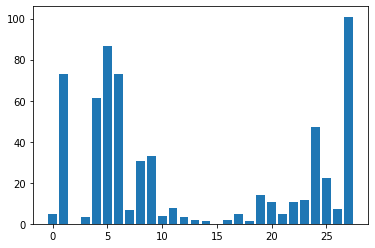

In [40]:
from sklearn.feature_selection import chi2, SelectKBest

# Separate continuous variables for this step, to be added back afterwards.
X_train_con = X_train.loc[:, ['age', 'fare', 'ticket_freq']]
X_train.drop(['age', 'fare', 'ticket_freq', 'ticket_freq'], axis=1, inplace=True)
# Separate continuous variables for this step, to be added back afterwards.
X_test_con = X_test.loc[:, ['age', 'fare', 'ticket_freq']]
X_test.drop(['age', 'fare', 'ticket_freq'], axis=1, inplace=True)
# Separate continuous variables for this step, to be added back afterwards.
df_test_trans_con = df_test_trans.loc[:, ['age', 'fare', 'ticket_freq']]
df_test_trans.drop(['age', 'fare', 'ticket_freq'], axis=1, inplace=True)

# Finally we scale our data - separately from categorical variables.
scaler = StandardScaler()

## Fit on training data set
# Random Forest performs better on un-scaled data.
names_training = list(X_train_con.columns.values)
_ = scaler.fit(X_train_con)
#X_train_new = scaler.transform(X_train_con)
#X_train_con = pd.DataFrame(X_train_new, columns=names_training)

# Apply to test data (training)
#X_test_new = scaler.transform(X_test_con)
#X_test_con = pd.DataFrame(X_test_new, columns=names_training)

# Scale age and fare on final dataset to final test data
#df_test_trans_new = scaler.transform(df_test_trans_con)
#df_test_trans_con = pd.DataFrame(df_test_trans_new, columns=names_training)

# Perform categorical feature selection
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
df_test_trans =  df_test_trans.astype(float)

names_before_select = list(X_train.columns.values)
print("Categorical variables names: {}".format(names_before_select))
best_feat = SelectKBest(chi2, k=15).fit(X_train, y_train)
mask = X_train.columns.values[best_feat.get_support()]
X_train_new = best_feat.transform(X_train)
X_train = pd.DataFrame(X_train_new, columns=mask)

X_test_new = best_feat.transform(X_test)
X_test = pd.DataFrame(X_test_new, columns=mask)

df_test_trans_new = best_feat.transform(df_test_trans)
df_test_trans = pd.DataFrame(df_test_trans_new, columns=mask)

# What are scores for the features
for i in range(len(mask)):
	print('%s: \t\t\t\t%f' % (mask[i], best_feat.scores_[i]))

# plot the scores
_ = pyplot.bar([i for i in range(len(best_feat.scores_))], best_feat.scores_)
pyplot.show()

# Add continuous variables back again.
X_train = pd.merge(X_train, X_train_con[['age', 'fare', 'ticket_freq']], left_index=True,
                   right_index=True)
X_test = pd.merge(X_test, X_test_con[['age', 'fare', 'ticket_freq']], left_index=True,
                  right_index=True)
df_test_trans = pd.merge(df_test_trans, df_test_trans_con[['age', 'fare', 'ticket_freq']],
                  left_index=True, right_index=True)

In [41]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
df_test_trans =  df_test_trans.astype(float)

Our final dataset for model building looks as follows:

In [42]:
X_train.head()

,is_married,title_Miss,title_Mr,title_Mrs,p_class_3,fam_size_small,fam_size_very_large,fare_bin_above_average,fare_bin_high,deck_BDE_male,deck_FG_male,deck_M_male,deck_BDE_female,deck_FG_female,deck_M_female,age,fare,ticket_freq
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.0,7.8958,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.0,7.9250,1.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,16.1000,2.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,7.2500,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45.0,13.5000,1.0


<h1 id = "build" style = "font-family:verdana; background-color:#C5D6FA"><center>Build models
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Building a series of models and
testing model accuracy</center></p>

We can now start building our first model, yay! We build and test a naive logistic regression
model - without any transformations or optimisations.

The objective is to ascertain the strength of association between features and responses on
unprocessed data.

## Naive Logistic Regression

In [43]:
# Initial model
log_reg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# Probability scores for test set
y_score_init = log_reg.fit(X_train, y_train).decision_function(X_test)

### Accuracy analysis

We start by considering the single most important classification metric, the ROC curve.

AUC: 0.8690047961630696


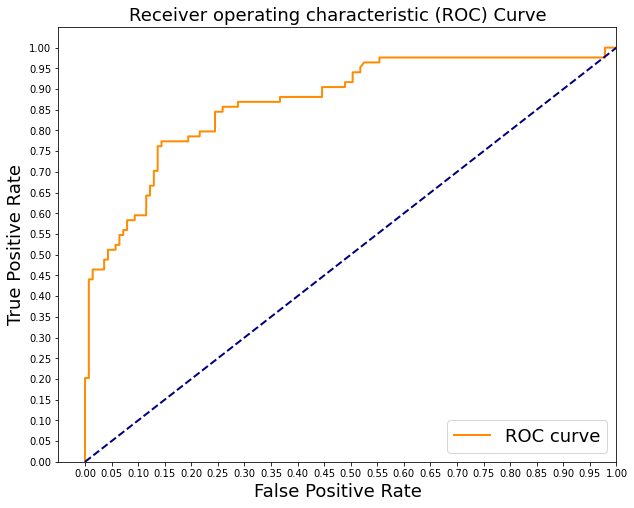

In [44]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score_init)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

The Area Under the ROC curve is 0.86 which is a good score for a classifier. We next
look the confusion matrix and various accuracy metrics derived from the confusion matrix
to gain more clarity.

Confusion matrix, without normalisation
[[120  19]
 [ 20  64]]
Normalised confusion matrix
[[0.86 0.14]
 [0.24 0.76]]


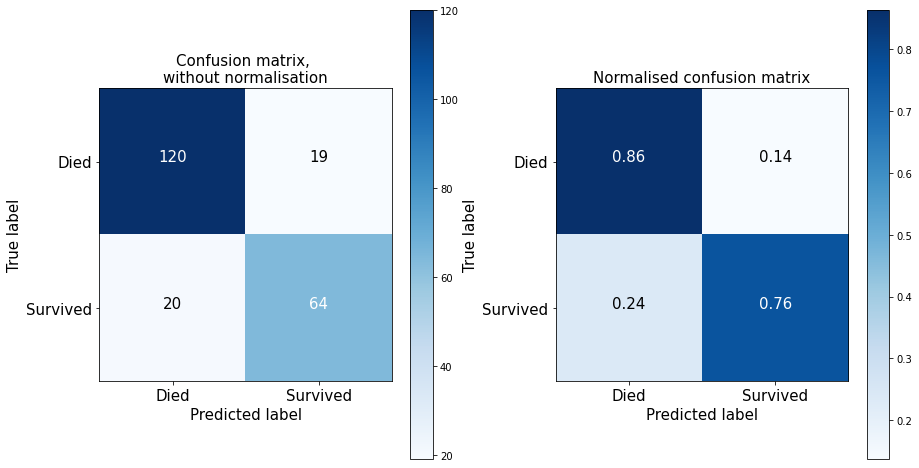


Accuracy:					0.82

Sensitivity/ Recall/ True Positive Rate:	0.76

Specificity/ Selectivity/ True Negative Rate:	0.86


Positive Predictive Value/ Precision:		0.77

Negative Predictive value:			0.86

False Positive rate/ Fall-out:			0.14

False Negative rate/ Miss Rate:			0.24

False Discovery rate:				0.23


In [45]:
y_pred = log_reg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['Died', 'Survived'])

The overall accuracy of the model is 79%, which is slightly higher than the Gender only
model which achieves 77%.

The model has a Sensitivity of 73%, which means that 73% of all survivors were correctly
identified. If this model was used for identifying inviduals for life insurance sales
prior to the journey, this means that 27% of survivors would have been missed for
potential sales (without incurring costs due to death). In real terms 23 out of 84
survivors were not identified as being survivors.

On the other hand the model achieved 83% for Specificity i.e. it correctly identified 115
 out of 139 individuals whom died.

The model has a precision of 72% which means that it correctly predicted 61 out of 85
individuals as surviving (the model predicted 85 survivors instead of 84 actual survivors).

## Naive MLP

In [46]:
# Fit and check MSE before regularisation
mlp_reg = MLPClassifier(max_iter=50000, solver="adam", activation="tanh", hidden_layer_sizes=(5, 5),
                    random_state=1)
mlp_reg = mlp_reg.fit(X_train, y_train)

# Predict
y_pred = mlp_reg.predict(X_test)

### Accuracy analysis

AUC: 0.7530832476875642


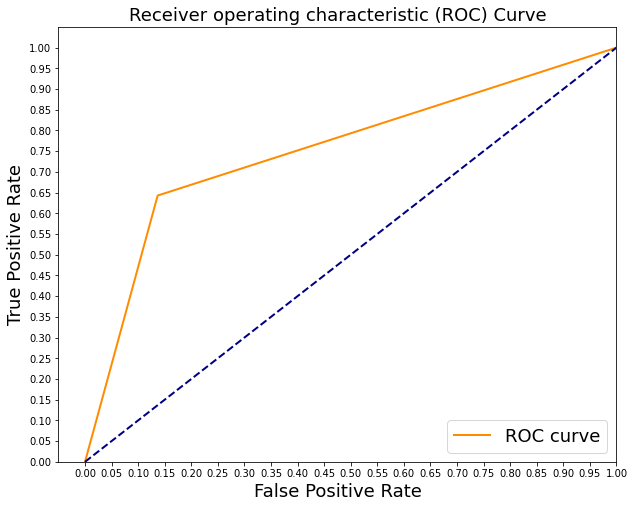

Confusion matrix, without normalisation
[[120  30]
 [ 19  54]]
Normalised confusion matrix
[[0.8  0.2 ]
 [0.26 0.74]]


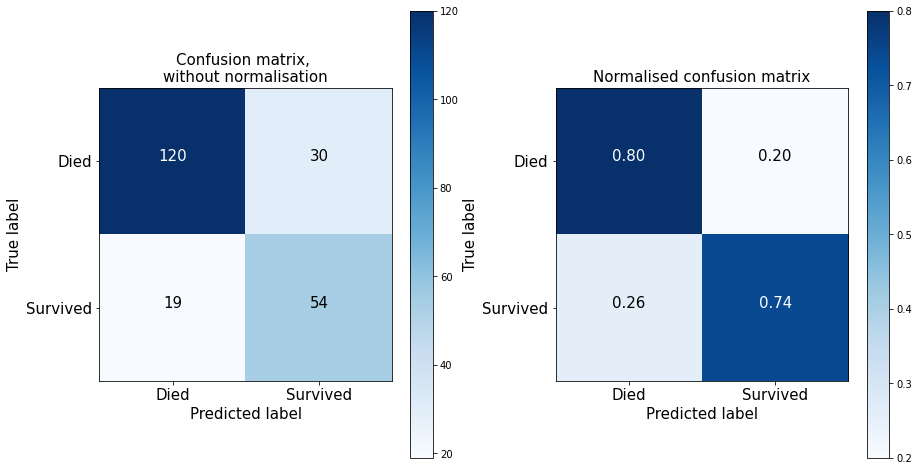


Accuracy:					0.78

Sensitivity/ Recall/ True Positive Rate:	0.74

Specificity/ Selectivity/ True Negative Rate:	0.80


Positive Predictive Value/ Precision:		0.64

Negative Predictive value:			0.86

False Positive rate/ Fall-out:			0.20

False Negative rate/ Miss Rate:			0.26

False Discovery rate:				0.36


In [47]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=['Died', 'Survived'])

The naive MLP has an AUC score of 75% which is lower than the base model score of 79%.

Let us see what the Learning Curve for the naive MLP looks like.

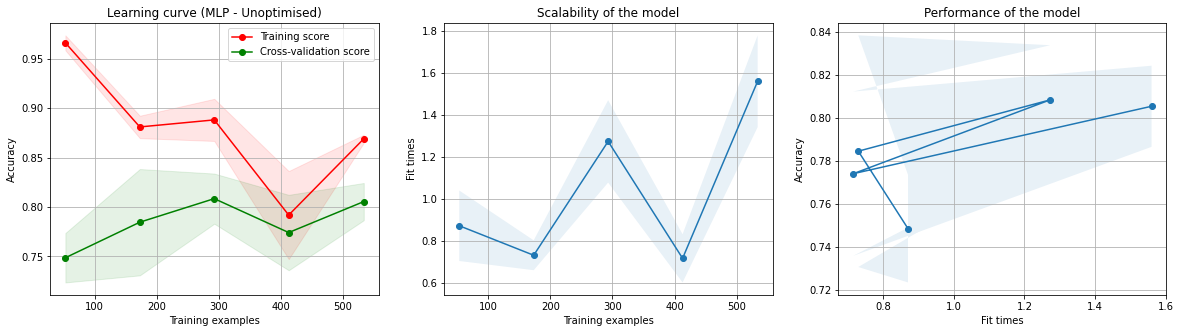

In [48]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (MLP - Unoptimised)"
_ = plot_learning_curve(mlp_reg, title, X_train, y_train, cv=None, n_jobs=-1,
                        learn_scoring="accuracy", scoring_title="Accuracy")


The learning curve for the un-optimised MLP shows the following:

- The MLP predicts 100% correctly for 1 example in training. This makes sense. With only one
 training sample the validation accuracy is around 0.65, which is actually not bad for 1
 training example.
- The model learns consistently and fast over the first 400 observations, validation
accuracy increases from 0.65 to 0.8.
- The model accuracy on the training set reduces from 1 to around 0.85 during this interval,
which is not a significant drop given the increase in training set size.
- The accuracy on the training set increases to close to 0.85 towards 500 training samples
and continues to climb (the validation accuracy at this point however decreases i.e.
inversely proportional to the training accuracy which indicates over-fitting).

Base on these observations we can draw the following conclusions:

- The model performs very well on a small dataset with only a few variables.
- There is scope for an increase in learning rate during the first 400 training samples.
Better feature engineering is a possible means of attaining an increased learning rate.
- The model overfits after 400 training samples. Regularisation or other measures to avoid
overfitting could maybe help. It would help to have validation accuracy increase along with
training post 400 samples, as this is quite a small sample size to begin with.

## Optimised MLP

We now optimise both the number of hidden layers, nodes as well the regularisation parameter
 <i>alpha</i>.

In [49]:
# Optimise numbers of nodes on both layers
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(2,6) for j in range(2,6)]:

    reg = MLPClassifier(max_iter=1000000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

Nodes |Validation
      | score
(2, 2) : 0.71557
(2, 3) : 0.61377
(2, 4) : 0.80988
(2, 5) : 0.71856
(3, 2) : 0.81886
(3, 3) : 0.71557
(3, 4) : 0.80838
(3, 5) : 0.80838
(4, 2) : 0.82036
(4, 3) : 0.80389
(4, 4) : 0.81886
(4, 5) : 0.82934
(5, 2) : 0.72904
(5, 3) : 0.79341
(5, 4) : 0.78593
(5, 5) : 0.80838


In [50]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )


The highest validation score is: 0.8293
This corresponds to nodes (4, 5)


Now we optimise the neural network regularisation parameter.

 alpha  |  Accuracy
0.13534 |  0.8068862275449101
0.22313 |  0.8038922155688623
0.36788 |  0.8068862275449102
0.60653 |  0.8038922155688624
1.00000 |  0.811377245508982
1.64872 |  0.811377245508982
2.71828 |  0.8218562874251497
4.48169 |  0.812874251497006
7.38906 |  0.8188622754491018
12.18249 |  0.7859281437125748
20.08554 |  0.6646706586826348
33.11545 |  0.6137724550898204


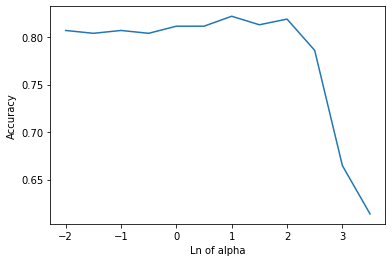

In [51]:
# Select range over which to find regularisation parameter - exponential used for even
# distribution of values
reg_par = [np.e**n for n in np.arange(-2,4,0.5)]

validation_scores = {}
print(" alpha  |  Accuracy")
for param in reg_par:
    reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh",
                        hidden_layer_sizes=optimal_hidden_layer_size, alpha=param, random_state=1)
    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2, scoring="accuracy")
    validation_scores[param] = score.mean()
    print("%0.5f |  %s" % (param, score.mean()))

# Plot the accuracy function against regularisation parameter
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()));
plt.xlabel("Ln of alpha");
plt.ylabel("Accuracy");

The highest cross-validation accuracy score and hence the value to use for the `alpha` parameter
is as follows.

In [52]:
max_score = ([np.log(name) for name, score in validation_scores.items() if score==max
(validation_scores.values())][0])
# Find lowest value.
print("The highest accuracy score is: %s" % (max(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" % max_score)

The highest accuracy score is: 0.8218562874251497
This corresponds to regularisation parameter e**1.0


MSE after regularisation

In [53]:
# Fit data with the best parameter
mlp_reg_optim = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh",
                    hidden_layer_sizes=optimal_hidden_layer_size, alpha=np.e**(max_score),
                              random_state=1)

mlp_reg_optim.fit(X_train, y_train)

# Predict
y_pred = mlp_reg_optim.predict(X_test)

MLPClassifier(activation='tanh', alpha=2.718281828459045, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(4, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Accuracy analysis

AUC: 0.7959917780061665


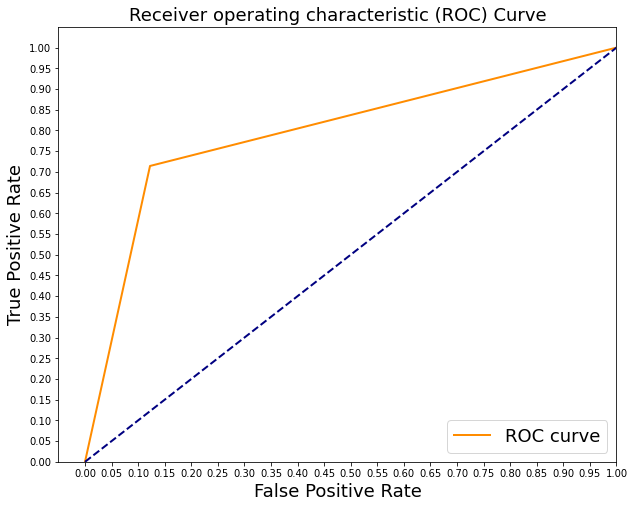

Confusion matrix, without normalisation
[[122  24]
 [ 17  60]]
Normalised confusion matrix
[[0.84 0.16]
 [0.22 0.78]]


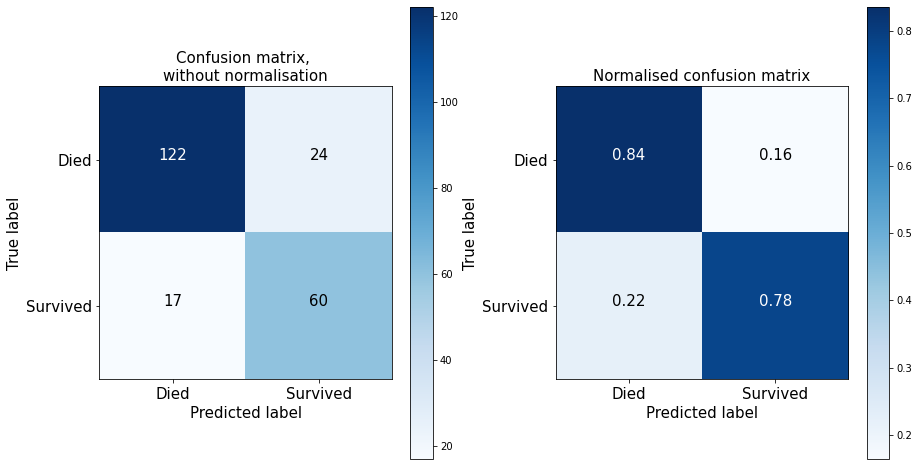


Accuracy:					0.82

Sensitivity/ Recall/ True Positive Rate:	0.78

Specificity/ Selectivity/ True Negative Rate:	0.84


Positive Predictive Value/ Precision:		0.71

Negative Predictive value:			0.88

False Positive rate/ Fall-out:			0.16

False Negative rate/ Miss Rate:			0.22

False Discovery rate:				0.29


In [54]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=['Died', 'Survived'])

The optimised MLP has an AUC score of 74%. The model accuracy is 77% which is not better
than the gender only model. The PPV is however lower at 64%, due to the model predicting
more individuals to survive (but wrongly). The model Sensitivity is however similar to
other models in that it manages to correctly 71% of survivors. It however identifies
fewer individuals who died correctly at 80% Specificity.

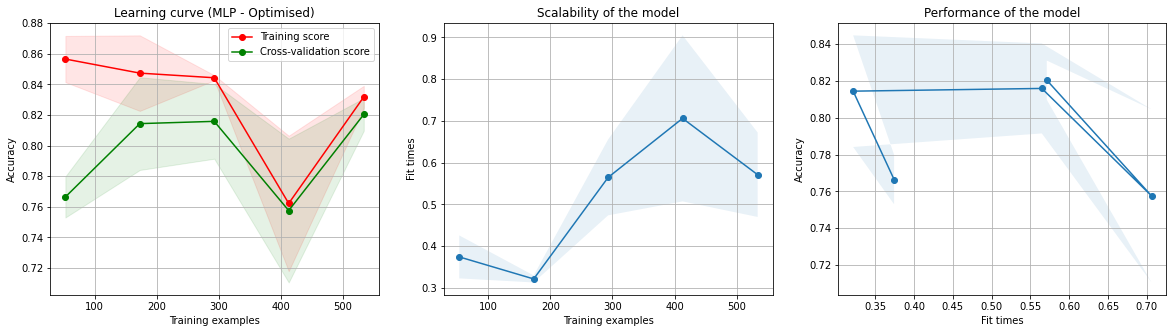

In [55]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (MLP - Optimised)"
_ = plot_learning_curve(mlp_reg_optim, title, X_train, y_train, cv=None, n_jobs=-1,
                        learn_scoring="accuracy", scoring_title="Accuracy")


The learning curve for the optimised MLP shows the following:

- Regularisation decreases 100% accuracy on 1 training sample to just below 0.9, which shows
 regularisation is working well.
- The training accuracy drops at the same rate but drops to below 0.86 which is where it
turned before.
- The validation set accuracy now drops at around 300 samples, which is earlier than before.
- The validation accuracy increase post 400 samples in in unison with the training accuracy.

Based on these observations we can draw the following conclusions:

- Validation resulted in the accuracy of the model increasing beyond 400 samples, which
shows that over-fitting has been addressed to some extent.
- More data at this point would benefit the model.


In [56]:
train_scores, test_scores = validation_curve(mlp_reg_optim, X_train, y_train, "alpha",
                                             reg_par, cv=None, scoring="accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Reverse scores to plot increasing complexity
train_scores_mean_rev = train_scores_mean[::-1]
train_scores_std = train_scores_std[::-1]
test_scores_mean_rev = test_scores_mean[::-1]
test_scores_std = test_scores_std[::-1]
reg_par_rev = reg_par[::-1]


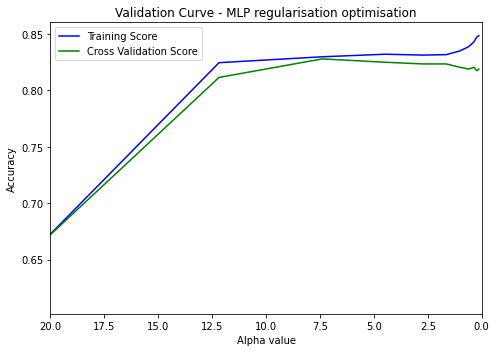

In [57]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot mean accuracy scores for training and testing scores
_ = ax.plot(reg_par_rev, train_scores_mean_rev, label = "Training Score", color = 'b')
_ = ax.plot(reg_par_rev, test_scores_mean_rev, label = "Cross Validation Score", color = 'g')

# Creating the plot
_ = ax.set_xlim(20, 0)
_ = ax.set_title("Validation Curve - MLP regularisation optimisation")
_ = ax.set_xlabel("Alpha value")
_ = ax.set_ylabel("Accuracy")

_ = plt.tight_layout()
_ = plt.legend(loc = 'best')
_ = plt.show()


The validation curve based on training and testing set validation shows that the optimal
parameter value of 1 previously attained with Cross Validation looks accurate.

The curve is however disappointing in that the validation curve diverges from the training
curve at a value of around 12.5 and then doesn't really increase convincingly afterwards.
From this curve it seems as if more needs to be done to reduce over-fitting of this model.

One possible option is to drop features which introduce multi-collinearity in the model.

## Optimised Decision Tree

We now build a Decision Tree to see it performs against the previous models. We also use
the Decision Tree to calculate feature importance. This will provide us with a better feeling for
 strength of association between features and the response.

In [58]:
# Fit a Decision Tree to data
samples = [sample for sample in range(1,30)]
validation_scores = []
for sample in samples:
    classifier1 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier1, X=X_train, y=y_train, cv=5)
    validation_scores.append(score.mean())

# Obtain the minimum leaf samples with the highest validation score
samples_optimum = samples[validation_scores.index(max(validation_scores))]

classifier2 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Feature importances for the Decision Tree is as follows:

Feature: is_married	Score:	0.00000
Feature: title_Miss	Score:	0.00000
Feature:   title_Mr	Score:	0.53113
Feature:  title_Mrs	Score:	0.00031
Feature:  p_class_3	Score:	0.13682
Feature: fam_size_small	Score:	0.02146
Feature: fam_size_very_large	Score:	0.00000
Feature: fare_bin_above_average	Score:	0.00321
Feature: fare_bin_high	Score:	0.00000
Feature: deck_BDE_male	Score:	0.00000
Feature: deck_FG_male	Score:	0.00000
Feature: deck_M_male	Score:	0.00000
Feature: deck_BDE_female	Score:	0.00238
Feature: deck_FG_female	Score:	0.00000
Feature: deck_M_female	Score:	0.00722
Feature:        age	Score:	0.06478
Feature:       fare	Score:	0.22244
Feature: ticket_freq	Score:	0.01026


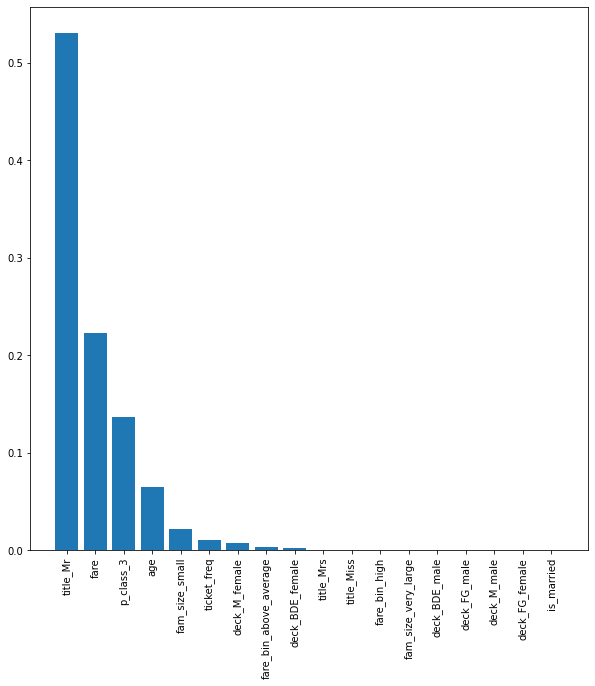

In [59]:
cols_model = X_train.columns.to_list()

importances = np.array(classifier2.feature_importances_)
feature_list = np.array(cols_model)

# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %10s\tScore:\t%.5f' % (feature_list[i],v))
# plot feature importance
sorted_ID=np.array(np.argsort(importances)[::-1])
plt.figure(figsize=[10,10])
plt.xticks(rotation='vertical')
_ = plt.bar(feature_list[sorted_ID], importances[sorted_ID]);
plt.show();

Here we have an interesting turn of events. The previously most important features was sex,
but has now been replaced by title_Mr. Passenger class and family size are in 2nd and 3rd
places.

### Accuracy analysis

AUC: 0.8233984241178486


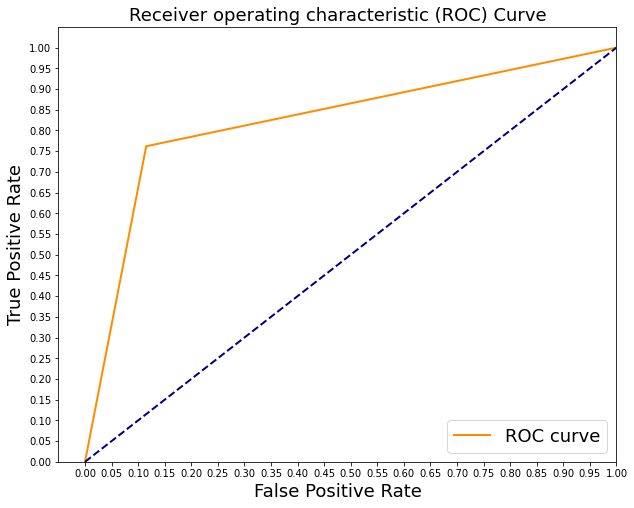

Confusion matrix, without normalisation
[[123  20]
 [ 16  64]]
Normalised confusion matrix
[[0.86 0.14]
 [0.2  0.8 ]]


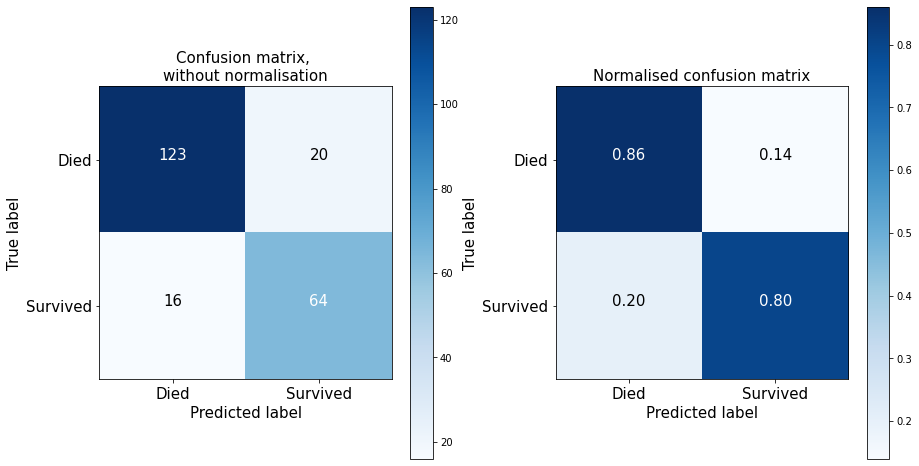


Accuracy:					0.84

Sensitivity/ Recall/ True Positive Rate:	0.80

Specificity/ Selectivity/ True Negative Rate:	0.86


Positive Predictive Value/ Precision:		0.76

Negative Predictive value:			0.89

False Positive rate/ Fall-out:			0.14

False Negative rate/ Miss Rate:			0.20

False Discovery rate:				0.24


In [60]:
# Probability scores for test set
y_pred = classifier2.predict(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=['Died', 'Survived'])

The Decision Tree obtained an AUC score of 81% which is the highest so far.

Sensitivity is also the highest at 84%. Specificity also does very well at 83%. This
model misses 11 out of 68 individuals whom survived, which is better for insurance
purposes than the base model.

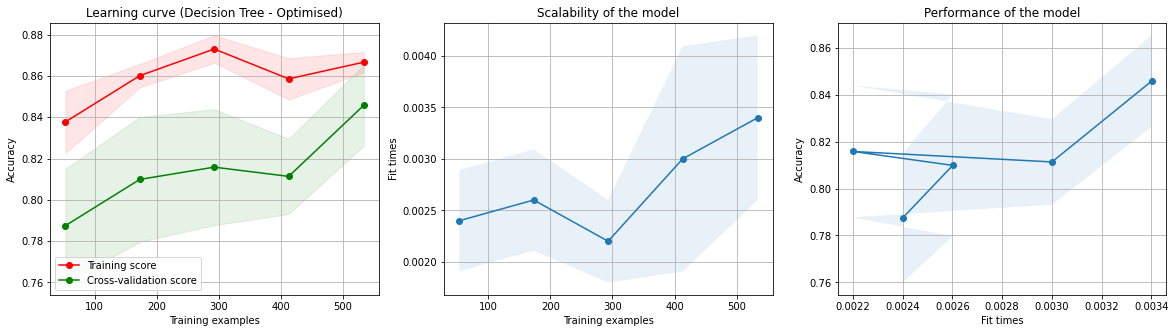

In [61]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (Decision Tree - Optimised)"
_ = plot_learning_curve(classifier2, title, X_train, y_train, cv=None, n_jobs=-1,
                        learn_scoring="accuracy", scoring_title="Accuracy")

## Naive Random Forest
Now we build a Random Forest and see what happens!

In [62]:
rand_forest = RandomForestClassifier(criterion= 'gini', random_state=0)
rand_forest.fit(X_train, y_train)

# Probability scores for test set
y_pred = rand_forest.predict(X_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Accuracy analysis

AUC: 0.7948783830078794


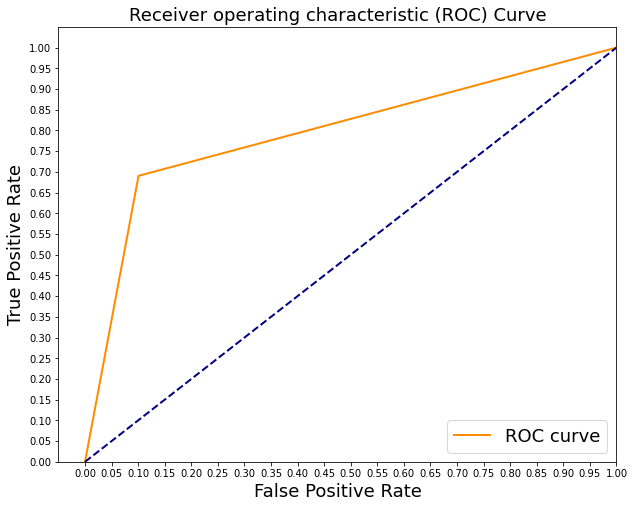

Confusion matrix, without normalisation
[[125  26]
 [ 14  58]]
Normalised confusion matrix
[[0.83 0.17]
 [0.19 0.81]]


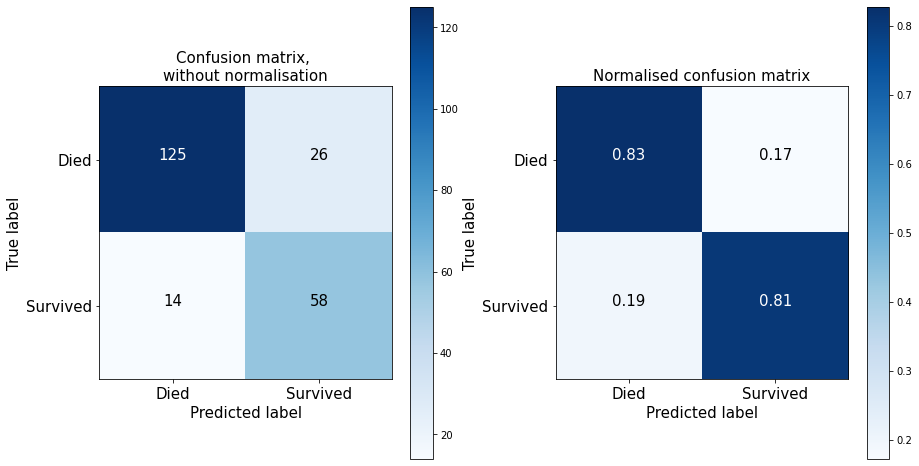


Accuracy:					0.82

Sensitivity/ Recall/ True Positive Rate:	0.81

Specificity/ Selectivity/ True Negative Rate:	0.83


Positive Predictive Value/ Precision:		0.69

Negative Predictive value:			0.90

False Positive rate/ Fall-out:			0.17

False Negative rate/ Miss Rate:			0.19

False Discovery rate:				0.31


In [63]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=['Died', 'Survived'])

The Random Forest obtained an AUC score of 77% which is lower than the Decision Tree!
This is unexpected. The Sensitivity is also lower at 75%.

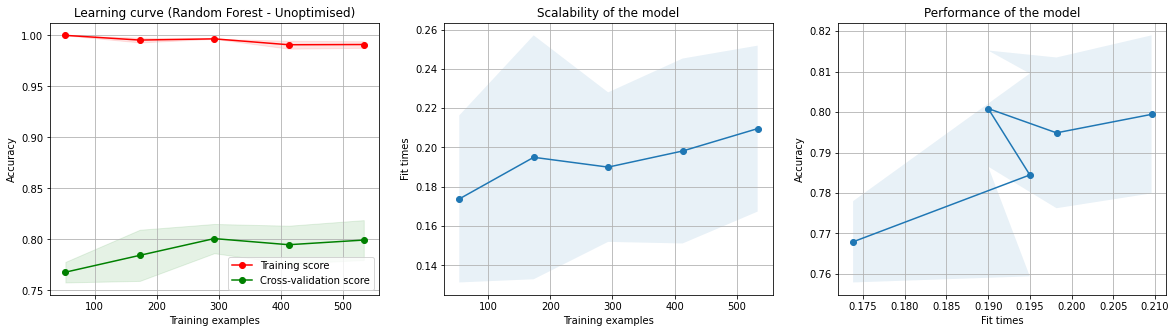

In [64]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (Random Forest - Unoptimised)"
_ = plot_learning_curve(rand_forest, title, X_train, y_train, cv=None, n_jobs=-1,
                        learn_scoring="accuracy", scoring_title="Accuracy")


The learning curve for the un-optimised Random Forest shows the following:

- As for the un-optimised MLP the un-optimised Random Forest has a 100% accuracy on one
training sample for the training set, which makes sense.
- The accuracy for one training sample on the validation set is around 75% which is better
than the MLP.
- The model shows large variance which is expected. Optimisation will assist with this. The
training set obtains an accuracy of above 90%.
- The maximum validation set accuracy is just above 80%.

## Optimised Random Forest

In [65]:
rand_forest = RandomForestClassifier(max_features='auto')
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12], "n_estimators": [50, 100, 400, 700]}
gs = GridSearchCV(estimator=rand_forest, param_grid=param_grid, scoring='accuracy', cv=3,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [66]:
gs.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 400}

In [67]:
# Final prediction - MLP
#rand_forest = RandomForestClassifier(criterion= 'gini', min_samples_leaf=5,
#                                     min_samples_split=2, n_estimators=100, random_state=0)
rand_forest = RandomForestClassifier(criterion= 'entropy', min_samples_leaf=5,
                                     min_samples_split=4, n_estimators=100, random_state=0)
rand_forest.fit(X_train, y_train)
#rand_forest.fit(x_train_prev, y_train)

# Probability scores for test set
y_pred = rand_forest.predict(X_test)
#y_pred = rand_forest.predict(x_test_prev)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Feature:             title_Mr	Score:	0.21975
Feature:                 fare	Score:	0.14450
Feature:                  age	Score:	0.12928
Feature:            p_class_3	Score:	0.09555
Feature:        deck_M_female	Score:	0.08091
Feature:          ticket_freq	Score:	0.06856
Feature:           title_Miss	Score:	0.06112
Feature:          deck_M_male	Score:	0.05264
Feature:           is_married	Score:	0.04077
Feature:            title_Mrs	Score:	0.03467
Feature:       fam_size_small	Score:	0.03399
Feature: fare_bin_above_average	Score:	0.01574
Feature:      deck_BDE_female	Score:	0.00565
Feature:         deck_FG_male	Score:	0.00470
Feature:        deck_BDE_male	Score:	0.00434
Feature:  fam_size_very_large	Score:	0.00339
Feature:        fare_bin_high	Score:	0.00298
Feature:       deck_FG_female	Score:	0.00145


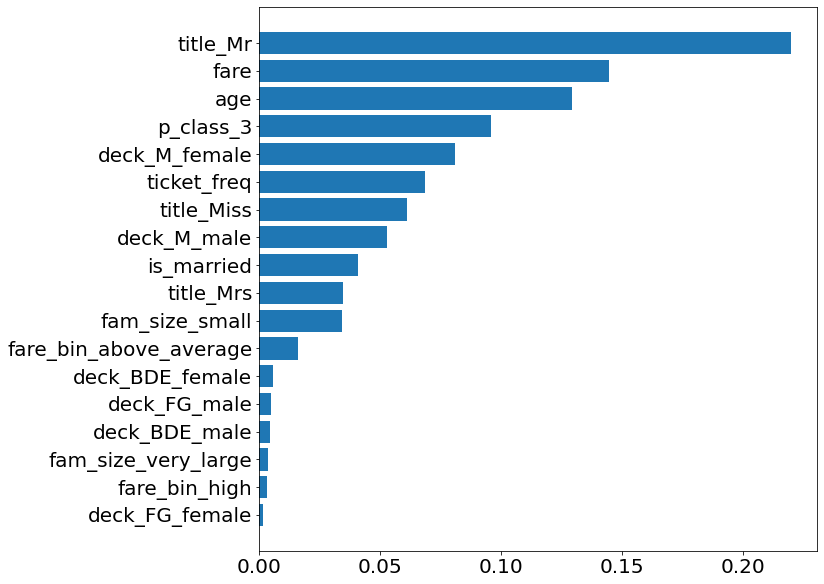

In [68]:
importances = np.array(rand_forest.feature_importances_)
feature_list = np.array(X_train.columns)
importances = np.array(importances)
sorted_ID=np.array(np.argsort(importances))
reverse_features = feature_list[sorted_ID][::-1]
reverse_importances = importances[sorted_ID][::-1]

for i,v in enumerate(reverse_importances):
    print('Feature: %20s\tScore:\t%.5f' % (reverse_features[i],v))

# Plot feature importance
#sorted_ID=np.array(np.argsort(scores)[::-1])
#sns.set(font_scale=1);
_ = plt.figure(figsize=[10,10]);
_ = plt.xticks(rotation='horizontal', fontsize=20)
_ = plt.barh(feature_list[sorted_ID], importances[sorted_ID], align='center');
_ = plt.yticks(fontsize=20)
_ = plt.show();

### Accuracy analysis


AUC: 0.7959917780061665


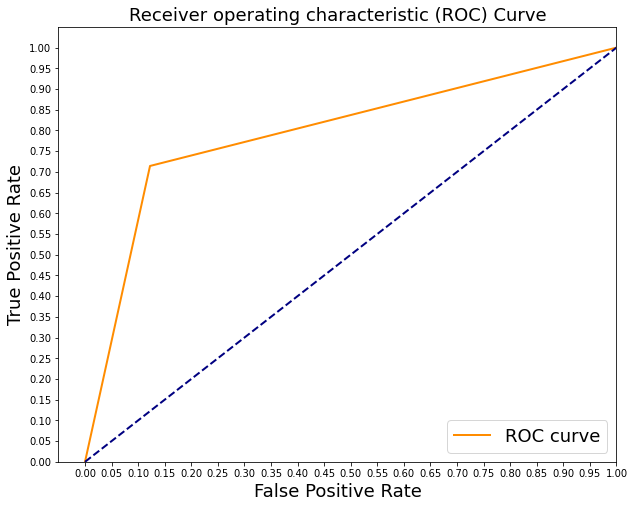

Confusion matrix, without normalisation
[[122  24]
 [ 17  60]]
Normalised confusion matrix
[[0.84 0.16]
 [0.22 0.78]]


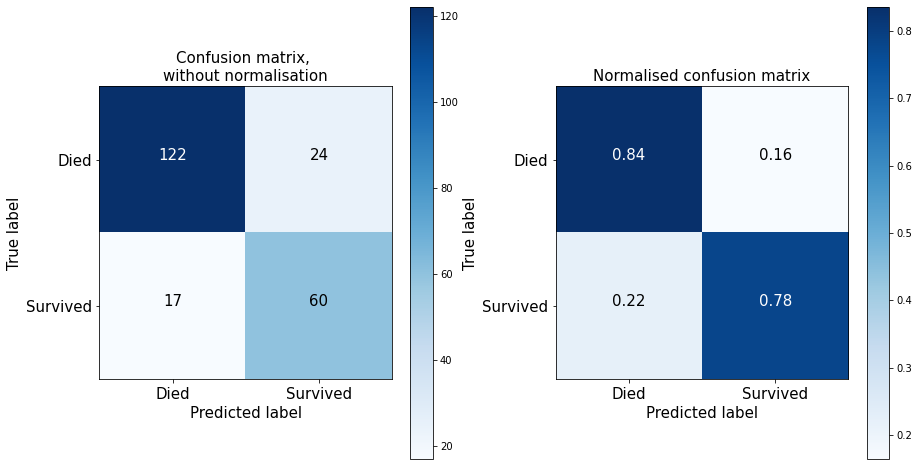


Accuracy:					0.82

Sensitivity/ Recall/ True Positive Rate:	0.78

Specificity/ Selectivity/ True Negative Rate:	0.84


Positive Predictive Value/ Precision:		0.71

Negative Predictive value:			0.88

False Positive rate/ Fall-out:			0.16

False Negative rate/ Miss Rate:			0.22

False Discovery rate:				0.29


In [69]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=['Died', 'Survived'])

The optimised Random Forest has an accuracy score of 81%. Sensitivity of 77% is however
still lower than the Decision Tree.


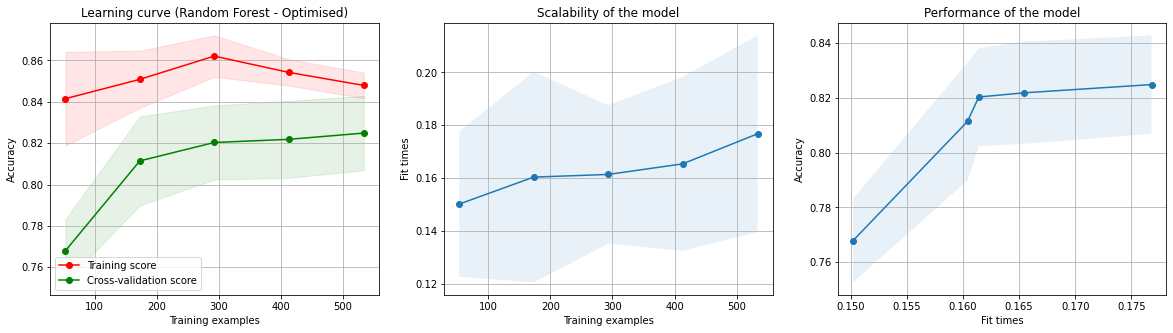

In [70]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (Random Forest - Optimised)"
_ = plot_learning_curve(rand_forest, title, X_train, y_train, cv=None, n_jobs=-1,
                        learn_scoring="accuracy", scoring_title="Accuracy")


The learning curve for the Optimised Random Forest shows the following:

- The accuracy for training starts at around 0.81 for the Random Forest. Optimisation has a
marked effect for accuracy on one training sample.
- Validation accuracy increases rapidly to above 0.8 before 200 samples are reached, which
shows variance has reduced substantially.
- Accuracy on validation remain at around 0.82 for the remainder of training samples.
- From 200 - 500 samples accuracy on the training set also remains constant at around 0.85.

<h1 id = "conclusion" style = "font-family:verdana; background-color:#C5D6FA"><center>Conclusion</center></h1>
<a class="anchor-link" href="https://www.kaggle.com/lourenswalters/i-titanic-baseline-models-0-78#conclusion">¶</a>
<p><center style="color:#1F4BA7; font-family:cursive;">What have we learnt?</center></p>

We can conclude that there is a strong signal in the data with regards to correlation
with survival rate. Counter-intuitively, the Logistic Regression proved to be the best
model scoring approximately 86% for the C-Statistic. The Random Forest classifier is second
with 81% for the C-Statistic. We would have expected the Random Forest to outperform the
Logistic Regression given all the categorical variables. The strong correlation between
age, fare and survival probably outweighed the categorical variable influence on survival
 rate. We expect the Random Forest to improve once we add more feature to the models.
 Also, in the name of speed we used scaled values for the Random Forest and it might
  do better on the original data. We will need to test this in the next notebook.

All in all, this was an insightful analysis. We found that the few variables we have are
very strong predictors for survival. In a real world setting further analysis is probably
 not necessary, as the gains from over-engineering variables for a model which does not
 have much practical value is probably not worthwhile.

This is however an educational exercise and hence we will go ahead and try to squeeze
more accuracy and insight out of the remaining variables. Focusing more on the insight
than accuracy, as at this point the model is probably accurate enough for any practical
application that might exist (which there obviously doesn't!).

On to the next notebook!


In [71]:
# Gender submission - Score: 0.77

# Final prediction - Random Forest - Score:  0.79665
y_pred = rand_forest.predict(df_test_trans)
y_pred = y_pred.astype(int)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_rand_forest.csv', index=False)

# Final prediction - MLP (optimised) - Score: ?
#mlp_reg_optim.fit(X, y)
y_pred = mlp_reg_optim.predict(df_test_trans)
y_pred = y_pred.astype(int)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_mlp_optim.csv', index=False)

# TODO: Final prediction - MLP (non-optimised) - Score: ?
y_pred = mlp_reg.predict(df_test_trans)
y_pred = y_pred.astype(int)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_mlp.csv', index=False)

# Final prediction - Logistic Regression - Score: ?
y_pred = log_reg.predict(df_test_trans)
y_pred = y_pred.astype(int)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_logreg.csv', index=False)

# Final prediction - Decision Tree - Score: ?
y_pred = classifier2.predict(df_test_trans)
y_pred = y_pred.astype(int)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_dec_tree.csv', index=False)